In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from drsa.model import DRSA

from pull_the_pitcher.data.pipeline import add_targets
from pull_the_pitcher.metrics import preds_histogram, print_all_metrics

from pybaseball import playerid_lookup

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
embedding_cols = ["pitcher"] # ["game_pk",  "game_type", "pitcher_team_year"]
feature_cols = ["post_bat_score", "score_diff", "end_inning", "inning", "postouts", "cum_sb_ratio",
                "times_thru_order", "post_total_runners", "tying_run_on", "pitch_total", "post_opposite_hand",
                "walk", 'walk_cumsum', 'strikeout_cumsum', 'home_run_cumsum', 'bases_cumsum']
cols = embedding_cols + feature_cols

In [3]:
train = pd.read_csv("../data/processed/train_2017_2018_2016.csv")
val = pd.read_csv("../data/processed/val_2017_2018_2016.csv")
test = pd.read_csv("../data/processed/test_2019.csv")

with open("../data/processed/mappers_2017_2018_2016_2019.pkl", "rb") as f:
    mappers = pickle.load(f)
    
with open("../data/processed/scaler_2017_2018_2016_2019.pkl", "rb") as f:
    scaler = pickle.load(f)
    
# scaling test data (as tuned on training data)
test[feature_cols] = scaler.transform(test[feature_cols])

# replacing pitcher id with index of associated embedding
test["pitcher"] = [mappers["pitcher"].get(pitcher, 0) for pitcher in test["pitcher"]]

In [4]:
def name2id(last, first):
    lookup_table = playerid_lookup(last, first)
    id = lookup_table.iloc[0, 2]
    return id

In [5]:
cole_id = name2id("cole", "gerrit")
verlander_id = name2id("verlander", "justin")

Gathering player lookup table. This may take a moment.
Gathering player lookup table. This may take a moment.


In [6]:
cole_emb_idx = mappers["pitcher"][cole_id]
verlander_emb_idx = mappers["pitcher"][verlander_id]

In [7]:
def save_model(m, p): torch.save(m.state_dict(), p)
def load_model(m, p): m.load_state_dict(torch.load(p))

In [9]:
# getting embeddings ready
n_pitchers = 270
pitcher_emb_size = 20
pitcher_embeddings = nn.Embedding(n_pitchers, pitcher_emb_size)

ptp_embeddings = [pitcher_embeddings]

# initializing model
drsa = DRSA(n_features=17,
            hidden_dim=20,
            n_layers=5,
            embeddings=ptp_embeddings,
            output_size=1,
            LSTM_dropout=0.05,
            Linear_dropout=0.1)

In [10]:
load_model(drsa, f"../models/07-22-20_DRSA_2016_2017_2018_2019_loss_2.6064.pth")
drsa.eval()

DRSA(
  (lstm): LSTM(36, 20, num_layers=5, batch_first=True, dropout=0.05)
  (fc): Linear(in_features=20, out_features=1, bias=True)
  (linear_dropout): Dropout(p=0.1, inplace=False)
  (sigmoid): Sigmoid()
  (params_to_train): ModuleList(
    (0): Embedding(270, 20)
  )
)

In [11]:
pitcher_embeddings = [p for p in drsa.named_parameters() if p[0]=='params_to_train.0.weight'][0][1].detach()

In [12]:
pitcher_embeddings.shape

torch.Size([270, 20])

In [13]:
pitcher_embs_tsne = TSNE(n_components=2, learning_rate=10, init="pca").fit_transform(pitcher_embeddings)

In [14]:
pitcher_embs_tsne.shape

(270, 2)

Text(2.8845441341400146, -0.754178524017334, 'verlander')

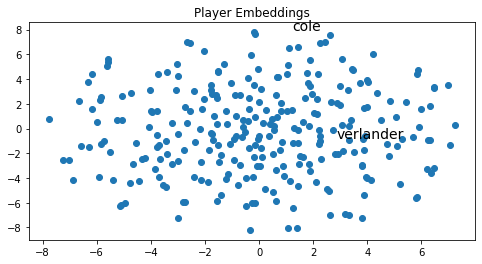

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.scatter(pitcher_embs_tsne[:, 0], pitcher_embs_tsne[:, 1])
ax.set_title("Player Embeddings")
ax.text(pitcher_embs_tsne[cole_emb_idx][0] - 1, pitcher_embs_tsne[cole_emb_idx][1] + 1, "cole", size=14)
ax.text(pitcher_embs_tsne[verlander_emb_idx][0] - 1, pitcher_embs_tsne[verlander_emb_idx][1] + 1, "verlander", size=14)

In [16]:
mlbam_id = pd.read_csv("mlbam_id.csv")

In [17]:
pitcher_id_df = pd.DataFrame(list(mappers["pitcher"].items()), columns=["mlb_id", "index"])
pitcher_id_df = pd.merge(mlbam_id[["MLBAMID", "Name"]], pitcher_id_df, how="inner", left_on=["MLBAMID"], right_on=["mlb_id"])

In [18]:
embs_df = pd.DataFrame(pitcher_embs_tsne, columns=["emb_1", "emb_2"]).reset_index()
embs_df = pd.merge(pitcher_id_df, embs_df, how="inner", on="index")

In [19]:
embs_df.head(2)

,MLBAMID,Name,mlb_id,index,emb_1,emb_2
0,456167,A.J. Griffin,456167.0,44,5.813855,-5.615535
1,592717,Aaron Sanchez,592717.0,166,1.054968,5.124578


In [31]:
embs_df.loc[embs_df["index"]==44]

,MLBAMID,Name,mlb_id,index,emb_1,emb_2
0,456167,A.J. Griffin,456167.0,44,5.813855,-5.615535


In [20]:
import altair as alt

alt.Chart(embs_df).mark_circle(size=60).encode(
    x='emb_1',
    y='emb_2',
    tooltip=['Name', 'mlb_id']
).interactive()

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html
